# Blood Type Evolution Model

## Import Dependencies

In [1]:
import mesa

# Data visualization tools.
import seaborn as sns

# Has multi-dimensional arrays and matrices. Has a large collection of
# mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

## Create Model and Agents

In [2]:
class HumanAgent(mesa.Agent):
    """An agent with some initial attribute values."""

    def __init__(self, model, sex, allele1, allele2, rhesus1, rhesus2, death_rate_dictionary, base_death_rate_stddeviation, reproduction_rate):
        # Pass the parameters to the parent class.
        super().__init__(model)

        # Create the agent's attributes and set the initial values.
        self.sex = sex
        self.genotype = [allele1, allele2] # Alleles for blood group only
        self.rhesus_factor = [rhesus1, rhesus2]
        self.phenotype = self.determine_phenotype()
        self.death_rate_dictionary = death_rate_dictionary
        self.base_death_rate_stddeviation = base_death_rate_stddeviation
        self.base_death_rate = self.assign_base_death_rate()
        self.adapted_death_rate = self.base_death_rate # Death rate is adapted at the beginning of next model step
        self.reproduction_rate = reproduction_rate


    def determine_phenotype(self):
        """Determine phenotype based on genotype."""        
        if "A" in self.genotype and "B" in self.genotype:
            blood_type = "AB"
        elif "A" in self.genotype:
            blood_type = "A"
        elif "B" in self.genotype:
            blood_type = "B"
        else:
            blood_type = "0"
        
        if "+" in self.rhesus_factor:
            rhesus = "+"
        else:
            rhesus = "-"
        
        return blood_type + rhesus


    def assign_base_death_rate(self):
        """Assign base death rate to agent depending on phenotype"""

        # Get average death rate for phenotype from dictionary
        average_death_rate = self.death_rate_dictionary[self.phenotype]
        # Assign unique death rate to agent following normal distribution around average death rate (rounded to 6 decimals)
        return round(self.random.normalvariate(average_death_rate, self.base_death_rate_stddeviation), 6)


    def die(self):
        """Agent dies with probability of individual death rate"""

        if self.random.random() < self.adapted_death_rate:
            self.remove()


    def reproduce(self):
        """Agent reproduces with probability of reproduction rate"""

        if self.random.random() < self.reproduction_rate:
            
            # Filter out agents with same gender
            possible_partners = self.model.agents.select(lambda a: a.sex != self.sex)

            # Check if agents with opposing gender exist
            if possible_partners:
                # Randomly select agent of opposing gender
                selected_partner = self.random.choice(possible_partners)

                # Debugging: Check sex/genotype of agent and partner
                """ print(f"Own sex: {self.sex}")
                print(f"Own genotype: {self.genotype}")
                print(f"Sex of partner: {selected_partner.__getattribute__("sex")}")
                print(f"Genotype of partner: {selected_partner.__getattribute__("genotype")}") """
                
                # Create new agent with random sex and random allele from father and random allele from mother
                sex = self.random.choice(["female", "male"])
                rhesus1 = self.random.choice(self.rhesus_factor)
                rhesus2 = self.random.choice(selected_partner.rhesus_factor)
                allele1 = self.random.choice(self.genotype)
                allele2 = self.random.choice(selected_partner.genotype)
                new_agent = HumanAgent(self.model, sex, allele1, allele2, rhesus1, rhesus2, self.death_rate_dictionary, self.base_death_rate_stddeviation, self.reproduction_rate)
                
                # Debugging: Check sex/genotype of new agent after reproduction
                """ print(f"Sex of new agent: {newAgent.get("sex")}")
                print(f"Genotype of new agent: {newAgent.get("genotype")}") """

            else:
                raise AssertionError("No reproduction possible. Only one gender present!")


    def mutate(self, new_allele):
        """Mutate one random allele of agent with newly introduced allele"""

        self.genotype[self.random.choice([0, 1])] = new_allele
        self.phenotype = self.determine_phenotype()
        self.base_death_rate = self.assign_base_death_rate()


    def adapt_death_rate(self, factor):
        """Adapt individual death rate of agent depending on population size"""

        self.adapted_death_rate = self.base_death_rate + factor
        



class BloodModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, duration, initial_allele, mutation_events, mutated_agents, death_rate_dictionary, base_death_rate_stddeviation, reproduction_rate, carrying_capacity, seed=None):
        super().__init__(seed=seed)
        self.population_size = n
        self.carrying_capacity = carrying_capacity
        self.duration = duration
        self.mutation_events = mutation_events
        self.mutated_agents = mutated_agents

        # Calculate factor for adapting death rate dynamically
        average_death_rate = sum(death_rate_dictionary.values()) / len(death_rate_dictionary)
        print(f"Average death rate: {average_death_rate}")
        self.alpha = reproduction_rate - average_death_rate
        print(f"Alpha: {self.alpha}\n")
        
        # Collect output data
        self.datacollector = mesa.DataCollector(
            agent_reporters={"Phenotype": "phenotype", "Genotype": "genotype", "Base Death Rate": "base_death_rate", "Adapted Death Rate": "adapted_death_rate"}
        )

        # Create agents
        for _ in range(n):
            rhesus1 = self.random.choice(['+', "-"])
            rhesus2 = self.random.choice(['+', "-"])
            a = HumanAgent(
                self,
                self.random.choice(["female", "male"]), 
                initial_allele, 
                initial_allele,
                rhesus1,
                rhesus2,
                death_rate_dictionary, 
                base_death_rate_stddeviation, 
                reproduction_rate
                )  # This calls the agent class parameter n number of times
 

    def mutation_event(self):
        """Introduce new alleles in random agents at defined simulation times"""

        # Iterate through all mutation events in dictionary
        for new_allele, event_time_fraction in self.mutation_events.items():
            # Check if the current step matches the defined mutation event time
            if self.steps == int(event_time_fraction * self.duration):
                print(f"Allele {new_allele} introduced at step {self.steps} (Current population size: {self.population_size})\nMutated agents:")
                # Trigger the mutation for the specified allele in a number of random agents
                for _ in range(self.mutated_agents):
                    possible_agents = self.agents.select(lambda a: a.genotype[0] != new_allele and a.genotype[1] != new_allele) # Only select agents which not already have the new allele to prevent double mutation
                    selected_agent = self.random.choice(possible_agents)
                    selected_agent.mutate(new_allele)

                    # Debugging: Check mutated agents
                    """ print(f"Agent ID: {selected_agent.unique_id}, Genotype: {selected_agent.genotype}, Phenotype: {selected_agent.phenotype}, Base Death Rate: {selected_agent.base_death_rate}, Adapted Death Rate: {selected_agent.adapted_death_rate}")
                print("\n") """


    def adapt_death_rate_of_agents(self):
        """Adapt death rate depending on population size"""

        # Update population size
        self.population_size = len(self.agents)

        # Debugging: Check population size
        print(f"Step: {self.steps}, Current population size: {self.population_size}")

        factor = (self.population_size/self.carrying_capacity)*self.alpha

        self.agents.do("adapt_death_rate", factor)
   
    
    def step(self):
        """Advance the model by one step."""

        # Collect data for each step
        self.datacollector.collect(self)

        self.adapt_death_rate_of_agents()
        
        self.mutation_event()

        self.agents.shuffle_do("die")

        self.agents.shuffle_do("reproduce")


        # Debugging: Check attributes of one unique agent at one specific time step
        """ step = 10
        unique_id = 5
        if self.steps == step:
            selected_agents = self.agents.select(lambda agent: agent.unique_id == unique_id)
            if selected_agents:
                unique_agent = selected_agents[0]
                print(f"Step: {step}, Agent ID: {unique_agent.unique_id}, Genotype: {unique_agent.genotype}, Phenotype: {unique_agent.phenotype}, Base Death Rate: {unique_agent.base_death_rate}, Adapted Death Rate: {unique_agent.adapted_death_rate}\n")

            else:
                print(f"No agent found with unique_id = {unique_id}\n") """

## Run Model

In [3]:
# Model Parameters
number_of_agents = 10 # Number of initial agents
duration = 5000 # Duration of simulation in steps
initial_allele = "0" # Initial allele at start of simulation
mutation_events = {"A": 0.1, "B": 0.2} # Dictionary for mutation events (New alleles introduced at fraction of simulation duration)
mutated_agents = 10 # Number of agents affected by mutation with new allele
death_rate_dictionary = {"0-": 0.006, "0+": 0.005, "A-": 0.005, "A+": 0.004, "B-": 0.004, "B+":0.003, "AB-": 0.004, "AB+": 0.003} # Dictionary for death rates depending on phenotype
reproduction_rate = 0.01
carrying_capacity = 500
base_death_rate_stddeviation = 0.0001 # Standard deviation for normally distributed base death rates of agents

model = BloodModel(number_of_agents, duration, initial_allele, mutation_events, mutated_agents, death_rate_dictionary, base_death_rate_stddeviation, reproduction_rate, carrying_capacity, seed=16)
for step in range(duration):
    model.step()


# TODO Flo: Change model parameters to reproduce distribution of blood types for Austria

# TODO Felix: Adjust death rates / reproduction rate to match a realistic time interval per step

# TODO Lukas: Batch run (running simulation several times)

Average death rate: 0.00425
Alpha: 0.00575

Step: 1, Current population size: 10
Step: 2, Current population size: 10
Step: 3, Current population size: 10
Step: 4, Current population size: 10
Step: 5, Current population size: 10
Step: 6, Current population size: 10
Step: 7, Current population size: 9
Step: 8, Current population size: 9
Step: 9, Current population size: 9
Step: 10, Current population size: 9
Step: 11, Current population size: 9
Step: 12, Current population size: 9
Step: 13, Current population size: 9
Step: 14, Current population size: 9
Step: 15, Current population size: 9
Step: 16, Current population size: 10
Step: 17, Current population size: 10
Step: 18, Current population size: 10
Step: 19, Current population size: 12
Step: 20, Current population size: 11
Step: 21, Current population size: 11
Step: 22, Current population size: 11
Step: 23, Current population size: 10
Step: 24, Current population size: 10
Step: 25, Current population size: 10
Step: 26, Current popula

## Data Analysis

        Phenotype Genotype  Base Death Rate  Adapted Death Rate
AgentID                                                        
19             0+   [0, 0]         0.004916            0.005744
24             0+   [0, 0]         0.005137            0.005965
42             0+   [0, 0]         0.004958            0.005786
44             0+   [0, 0]         0.004915            0.005743
50             0+   [0, 0]         0.005062            0.005890
...           ...      ...              ...                 ...
150            0+   [0, 0]         0.004954            0.005782
151            0+   [0, 0]         0.005031            0.005859
152            0+   [0, 0]         0.005034            0.005862
153            0+   [0, 0]         0.005075            0.005903
154            A+   [0, A]         0.003988            0.005781

[71 rows x 4 columns]
Population size at end of simulation: 568


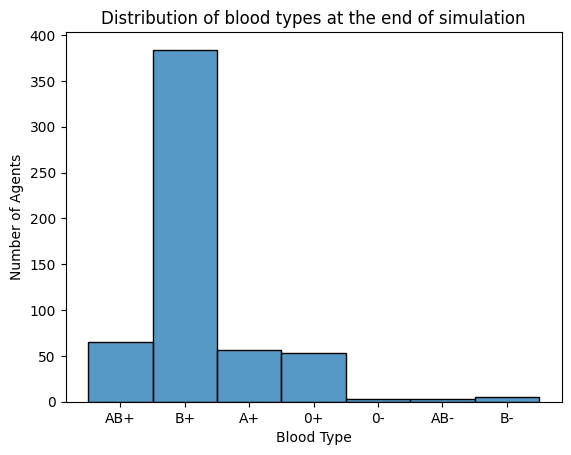

In [4]:
# Get full dataframe of simulation parameters from datacollector
dataframe = model.datacollector.get_agent_vars_dataframe()

# Debugging: Get data frame for specific step in simulation
print_step = 501
if print_step <= duration:
    print(dataframe.loc[print_step])
else:
    print("Data of step not available! (Simulation duration is shorter)")

# Extract phenotype distribution from last step of simulation 
last_step = dataframe.index.get_level_values("Step").max()
end_phenotype = dataframe.xs(last_step, level="Step")["Phenotype"]
print(f"Population size at end of simulation: {len(model.agents)}")

# Create a histogram of bloodtype distribution at the last step
g = sns.histplot(end_phenotype, discrete=True)
g.set(
    title="Distribution of blood types at the end of simulation",
    xlabel="Blood Type",
    ylabel="Number of Agents",
);

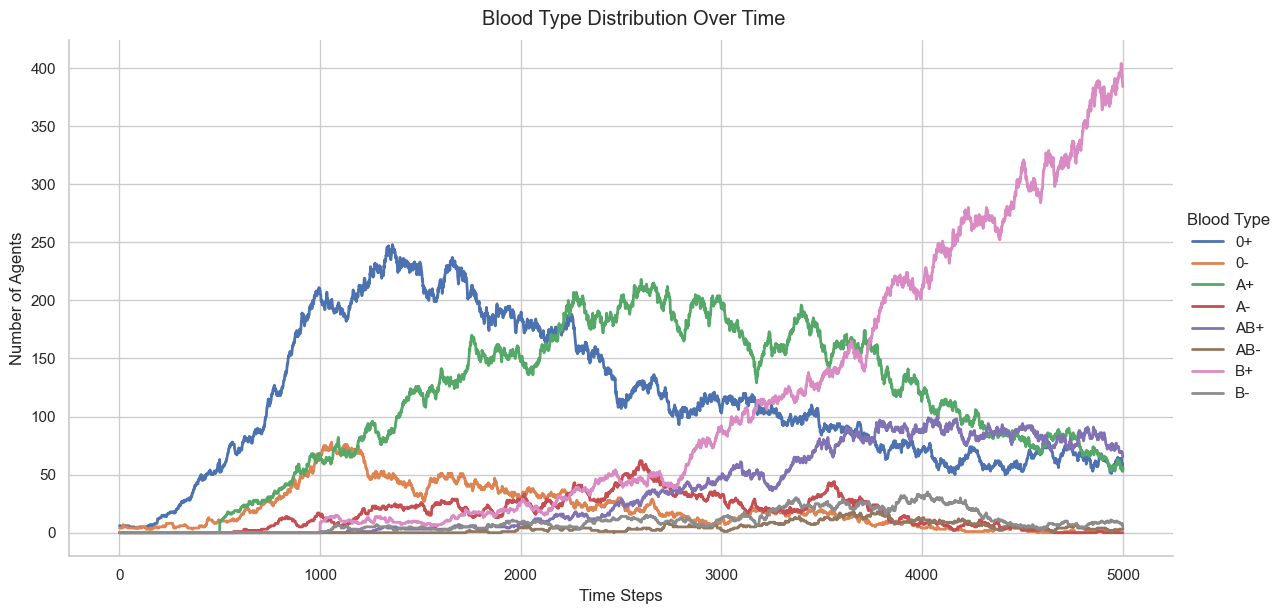

In [5]:
# Collect the data for blood type distribution over time
dataframe = model.datacollector.get_agent_vars_dataframe()

# Count occurrences of each phenotype (blood type) at each step
blood_type_over_time = dataframe.groupby(['Step', 'Phenotype']).size().unstack(fill_value=0).reset_index()

# Melt the data for Seaborn plotting
melted_data = blood_type_over_time.melt(id_vars='Step', var_name='Blood Type', value_name='Count')

# Create a Seaborn FacetGrid to manage the plot layout
sns.set_theme(style="whitegrid")
g = sns.relplot(
    data=melted_data,
    x="Step",
    y="Count",
    hue="Blood Type",
    kind="line",
    height=6,
    aspect=2,
    markers=True,
    linewidth=2
)

# Customize the plot
g.set_axis_labels("Time Steps", "Number of Agents")
g.figure.suptitle("Blood Type Distribution Over Time", y=1.02)  # Adjust title position
g.legend.set_title("Blood Type")